In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
from matplotlib import pyplot as plt 
import random
import pickle as pkls
import pandas as pd

#local files being imported
import platform_opt
from players import *
import sims
import sims_copy
from statistics import variance
#Note: when indexed as a list: group $A$ is 0, group $B$ is 1.
#      when indexed as a dict: group $A$ is -1, group $B$ is 1.

In [2]:
# SIMULATION PARAMETERS AGNOSTIC TO DATA
T = 5                 # max number of timesteps
M = 100000            # size of unit mass

#load parameters from dataset
dataset_name = 'twitter_abortion'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)

Don't run this next cell if you already know what the theta params are

In [3]:
#how to show articles at timestep 1
#epsilon for additive constraints (difference in expected exposure bounded by epsilon)
epsilon = 0.3

#params for ratio constraints
delta_low = 0.2
delta_high = 2
    
theta_additive = platform_opt.opt('additive',pi, q, T, c,v,beta_dist,epsilon=epsilon, exposure_e=0.1) #constrained with exposure equality
theta_opt = platform_opt.opt('unconstrained', pi, q, T, c,v,beta_dist) #unconstrained to optimize clicks
theta_ratio = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high, exposure_e=0.1) #constrained with exposure equality

#theta_opt = {1:1., -1:0.}
theta_half = {1: 0.5, -1: 0.5}

print(theta_additive)
print(theta_opt)
print(theta_ratio)

{-1: 0.1, 1: 0.3263292349913845}
{-1: 9.242537803114345e-31, 1: 1.0}
{-1: 0.10000000000000002, 1: 0.9000000000000004}


Run this if loading theta from previous runs.

In [4]:
#since the optimization in the following cell only needs to be run once per set of parameters


#T = 5, delta_low = 0.7, delta_high = 1.5, dataset_name = twitter_abortion, epsilon = 1e-2, exposure_e = 0.1
theta_ratio = {1: 0.2834815147245223, -1: 0.6107897012879441}
theta_additive = {1: 0.09999999999481513, -1: 0.5971257773943613}
theta_opt = {1:0., -1:1.}
theta_half = {1: 0.5, -1: 0.5}

In [5]:
trials_to_run = {'additive':theta_additive, 'half':theta_half, 'opt':theta_opt, 'ratio':theta_ratio}
num_trials = 10

given number of trials and which types of interventions we want to test, returns the outputs 

In [6]:
trials = [sims.runModel_samepop(T, pi, M, P, beta_dist, v,c,q, trials_to_run) for ix in range(num_trials)]
avg = sims.average_dfs(trials) #dict of dataframes

new way of saving the trials.  trials is a list of dicts of dataframes; dicts indexed by theta_type, and dataframes have number of players, shown, click, and share

In [7]:
sims.saveRuns(trials, 'same_init_runs/' + str(dataset_name) + '/trials.pkl')
sims.saveRuns(avg, 'same_init_runs/' + str(dataset_name) + '/averages.pkl')

new way to unpickle data

In [8]:
trials = sims.loadRuns('same_init_runs/' + str(dataset_name) + '/trials.pkl') #path not right
avg = sims.loadRuns('same_init_runs/' + str(dataset_name) + '/averages.pkl')


In [9]:
#average intergroup exposure and share
#normalized by number of impressions/clicks in model
#higher is better here

print('Intergroup exposure')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['shown'][i][(1,-1)] for i in range(len(avg[theta_type]['shown'].index))]))
    print(np.sum([avg[theta_type]['shown'][i][(-1,1)] for i in range(len(avg[theta_type]['shown'].index))]))
    #print(np.abs(np.sum([avg[theta_type]['shown'][i][(1,-1)] for i in range(len(avg[theta_type]['shown'].index))]) \
    #             - np.sum([avg[theta_type]['shown'][i][(-1,1)] for i in range(len(avg[theta_type]['shown'].index))])))
    #this absolute difference being high isn't bad: it means that the algo is compensating for class imbalance.
    
print('\nIntergroup shares')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['share'][i][(1,-1)] for i in range(len(avg[theta_type]['share'].index))]))
    print(np.sum([avg[theta_type]['share'][i][(-1,1)] for i in range(len(avg[theta_type]['share'].index))]))
    #print(np.abs(np.sum([avg[theta_type]['share'][i][(1,-1)] for i in range(len(avg[theta_type]['share'].index))]) \
    #             - np.sum([avg[theta_type]['share'][i][(-1,1)] for i in range(len(avg[theta_type]['share'].index))])))
    #this absolute difference being high isn't bad: it means that the algo is compensating for class imbalance.
    


Intergroup exposure
additive
33677.100000000006
38458.49999999999
half
19047.3
32165.899999999998
opt
37379.8
63469.9
ratio
26951.899999999998
39138.49999999999

Intergroup shares
additive
1120.1
132.6
half
638.4000000000001
115.39999999999999
opt
1232.1999999999998
198.5
ratio
896.2
134.1


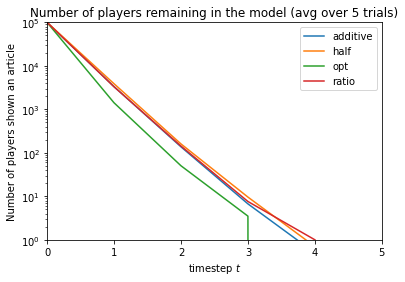

In [10]:
num_trials = len(avg['opt']['players_list'])
hehe= []

for theta_type in trials_to_run.keys():
    plt.plot(avg[theta_type]['players_list'])
    hehe.append(theta_type)

plt.title("Number of players remaining in the model (avg over %i trials)" % (num_trials))
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((1, M))
plt.legend(hehe)
#plt.legend(('Exposure-constrained $\\theta_{add}$', 'Unconstrained $\\tilde \\theta$', 'Half-exposure $\\theta_g = 1/2$'))
plt.show()

[None, None, None, None, None, None, None, None]

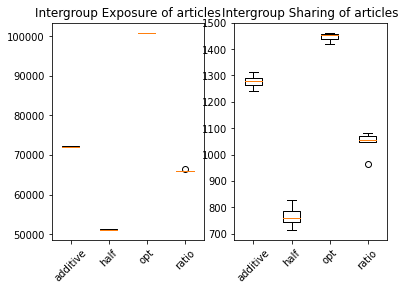

In [11]:
#calculate boxplot data
ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        + trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)]))
        ig_shares[theta_type].append(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        + trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)]))
    

        
# plot data
fig1, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('Intergroup Exposure of articles')
ax1.boxplot([value for key,value in ig_shown.items()], labels=ig_shown.keys())

ax2.set_title('Intergroup Sharing of articles')
ax2.boxplot([value for key,value in ig_shares.items()], labels=ig_shares.keys())

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

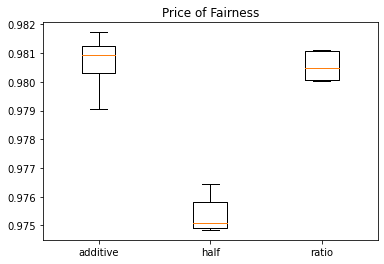

In [12]:
pof = {}
for theta_type in trials_to_run.keys():
    pof[theta_type] = [(trials[i]['opt']['players_list'].sum() / trials[i][theta_type]['players_list'].sum()) for i in range(num_trials)]

del(pof['opt'])

fig1, ax1 = plt.subplots()

ax1.set_title('Price of Fairness')
ax1.boxplot([value for key,value in pof.items()], labels=pof.keys())

plt.savefig('figures/pof.png')

[None, None, None, None, None, None, None, None]

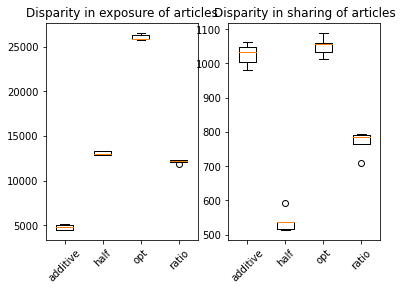

In [13]:
#calculate boxplots for difference in exposure 
#should be close to 0
# if np.abs removed, positive means article B shown more
#calculate boxplot data
ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.abs(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        - trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)])))
        ig_shares[theta_type].append(np.abs(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        - trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)])))
    

        
# plot data
fig1, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('Disparity in exposure of articles')
ax1.boxplot([value for key,value in ig_shown.items()], labels=ig_shown.keys())

ax2.set_title('Disparity in sharing of articles')
ax2.boxplot([value for key,value in ig_shares.items()], labels=ig_shares.keys())

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

Set of experiments to understand impact of additive epsilon.  Replicate with ratio epsilon

In [14]:
T=5
theta_A = {}
theta_B = {}
delta_low = 0.7
delta_high= 1.5
for exp in [0., 0.01, 0.05, 0.1, 0.2, 0.25]:
    #theta_fair = platform_opt.constrained(pi, q, T, c,v,beta_dist, delta_low, delta_high, exposure_e=exp) #constrained with exposure equality 
    theta_fair = platform_opt.opt_ratios(pi, q, T, c,v,beta_dist, delta_low, delta_high, exposure_e=exp) #constrained with exposure equality 
    theta_A[exp] = theta_fair[-1]
    theta_B[exp] = theta_fair[1]
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
eps_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples

list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples
eps_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples



AttributeError: module 'platform_opt' has no attribute 'opt_ratios'

In [ ]:
plt.plot(eps_A, thetaA, 'bo')
plt.plot(eps_B, thetaB, 'gx')
plt.xlim((-0.01,0.27))
plt.ylim((-0.05,1.05))
plt.title('$\\theta_A$ and $\\theta_B$ imposing exposure constraints; T = %i' % (T))
plt.legend(['$\\theta_A$', '$\\theta_B$'])
plt.xlabel('$\\gamma : \\theta_g \\in [\\gamma, 1-\\gamma]$')
plt.ylabel('$\\theta_g$')
plt.show()

experiment with ratio constraint parameters

In [ ]:
T=5
theta_A = {}
theta_B = {}
exposure_e = 0.1
for delta_low in [0.5, 0.7, 0.9, 0.95]:
    for delta_high in [1.1, 1.5, 2.]:
        theta_ratio = platform_opt.opt_ratios(pi, q, T, c,v,beta_dist, delta_low, delta_high, exposure_e=exposure_e) #constrained with exposure equality 
        theta_A[(delta_low, delta_high)] = theta_ratio[-1]
        theta_B[(delta_low, delta_high)] = theta_ratio[1]
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
hold_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples
delta_low_A, delta_high_A = zip(*hold_A)

list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples
hold_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples
delta_low_B, delta_high_B = zip(*hold_B)



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(delta_low_A, delta_high_A, thetaA)
ax.scatter(delta_low_B, delta_high_B, thetaB)

ax.set_xlabel('$\\delta_{low}$')
ax.set_ylabel('$\\delta_{high}$')
ax.set_zlabel('$\\theta_A$')

plt.show()

heatmap varying homophily constraint

In [ ]:
import numpy as np
import seaborn as sns
import pickle as pkl
import pandas as pd

#heatmap varying q_A and q_B
num_trials = 25
M = 100000
pi= {-1: 0.5, 1: 0.5}

T = 5
add_epsilon = 0.001        
delta_low = 0.7
delta_high = 1.5
c = {(1,1): 1., (-1,1): 1., (1,-1): 1., (-1,-1): 1.}
v = {( 1,  1):   2000.,
     (-1,  1):   500.,
     ( 1, -1):   500.,
     (-1, -1):   2000. }

beta_dist = {(1,1) : (1., 9.),
                    (-1,1) : (1., 29.),
                    (1,-1) : (1., 29.),
                    (-1,-1): (1., 9.)}

P = {}
for a in [-1,1]:
    for g in [-1,1]:
        P[(a,g)] = beta_dist[(a,g)][0] / (beta_dist[(a,g)][0] +  beta_dist[(a,g)][1])


share_list = []
ig_share_list = [] #intergroup shares

st = 0.1
n = np.arange(0.5, 1.01, step=st).shape[0]
data = np.zeros(n)
ig_data = np.zeros(n)




for k,q_A in enumerate(np.arange(0.5, 1.01, step=st)):
    q = {-1: q_A, 1: q_A}
    theta_fair = platform_opt.opt_constrained(pi, q, T, epsilon,c,v,beta_dist, exposure_e=0.0)
    for i in range(num_trials):
        players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
        share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys()]))
        ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] == -key[1]]))


    data[k] = np.mean(share_list)
    ig_data[k] = np.mean(ig_share_list)



In [ ]:
#fig, (ax1,ax2) = plt.subplots(1,2)
sns.set()
df = pd.DataFrame({"Total Shares": data, "Intergroup Shares": ig_data, "$q_A = q_B$" : np.round(np.arange(0.5, 1.01, step=st), 2)})

ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Total Shares", log=True)
plt.title("Effect of homophily on total number of shares")
plt.savefig('figures/homophily_shares.png')
plt.show()

ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Intergroup Shares", log=True)
plt.title("Effect of homophily on number of intergroup shares")
plt.savefig('figures/homophily_ig_shares.png')
plt.show()


In [ ]:
sims.saveRuns(df, 'same_init_runs/homophily_shares.pkl')

In [ ]:
#varying psi
#import numpy as np
#import seaborn as sns

#heatmap varying Psi
num_trials = 25
M = 10000
pi= {-1: 0.5, 1: 0.5}

T = 6
epsilon = 0.001        
c = {(1,1): 1., (-1,1): 1., (1,-1): 1., (-1,-1): 1.}

#beta_dist = {(1,1) : (0.9541492709534125, 1.345006644515015),
#                    (-1,1) : (0.1822515775580026, 2.7574965182522644),
#                    (1,-1) : (0.09576097403924465, 3.09136619146736),
#                    (-1,-1): (0.8828729918440646, 1.6247070146941363)}

beta_dist = {(1,1) : (1., 9.),
                    (-1,1) : (1., 29.),
                    (1,-1) : (1., 29.),
                    (-1,-1): (1., 9.)}

P = {}
for a in [-1,1]:
    for g in [-1,1]:
        P[(a,g)] = beta_dist[(a,g)][0] / (beta_dist[(a,g)][0] +  beta_dist[(a,g)][1])

q = {1: 0.8, -1: 0.8}

share_list = []
ig_share_list = [] #intergroup shares

st = 500
rng_min = 500
rng_max = 2501
n = np.arange(rng_min, rng_max, step=st).shape[0]
data_psi = np.zeros((n,n))
ig_data_psi = np.zeros((n,n))


for k,intra in enumerate(np.arange(rng_min, rng_max, step=st)):
    for j,inter in enumerate(np.arange(rng_min, rng_max, step=st)):
        v = {(1,1): intra, (-1,1): inter, (1,-1): inter, (-1,-1):intra }
        #print('v: ' + str(v))
        theta_fair = platform_opt.opt_constrained(pi, q, T, epsilon,c,v,beta_dist, exposure_e=0.0)
        #print('Theta:  ' + str(theta_fair))
        for i in range(num_trials):
            players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
            share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys()]) / sum(players_in_model_fair))
            ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] == -key[1]]) / sum(players_in_model_fair))
                     
        data_psi[k,j] = np.mean(share_list)
        ig_data_psi[k,j] = np.mean(ig_share_list)
                    


In [ ]:
import seaborn as sns 
print(data_psi)

sns.set()
ax = sns.heatmap(data_psi,cmap="Blues", xticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)], yticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on share rate")
plt.xlabel("intergroup $v$ value")
plt.ylabel("intragroup $v$ value")
plt.savefig('figures/heatmap_psi.png')
plt.show()



sns.set()
ax = sns.heatmap(ig_data_psi,cmap="Blues", xticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)], yticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on intergroup shares")
plt.xlabel("intergroup $v$ value")
plt.ylabel("intragroup $v$ value")
plt.savefig('figures/heatmap_psi_intergroup.png')
plt.show()


In [ ]:
sims.saveRuns(data_psi, 'simulation_data/heatmap_psi.pkl')
sims.saveRuns(ig_data_psi, 'simulation_data/heatmap_psi_intergroup.pkl')